In [1]:
import pandas as pd
import csv
from neo4j import GraphDatabase
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [98]:
neo4j_url = os.environ.get("NEO4J_URI")
neo4j_username = os.environ.get("NEO4J_USERNAME")
neo4j_password = os.environ.get("NEO4J_PASSWORD")

In [99]:
# Initialize the Neo4j driver
driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_username, neo4j_password))

In [20]:
source_file_path = "data/sepsis_final_data_RAW_withTimes_copy.csv"

In [3]:
source_file_path = "data/sepsis_final_data_withTimes.csv"


In [4]:
# Load the CSV file
# df = pd.read_csv(source_file_path, on_bad_lines='skip', sep=";")
df = pd.read_csv(source_file_path)
# View the first few rows
print(df.head())



   traj  step  m:presumed_onset   m:charttime  m:icustayid  o:gender  \
0     1     0      7.245590e+09  7.245486e+09     200003.0      -0.5   
1     1     1      7.245590e+09  7.245500e+09     200003.0      -0.5   
2     1     2      7.245590e+09  7.245515e+09     200003.0      -0.5   
3     1     3      7.245590e+09  7.245529e+09     200003.0      -0.5   
4     1     4      7.245590e+09  7.245544e+09     200003.0      -0.5   

   o:mechvent  o:max_dose_vaso  o:re_admission     o:age  ...    o:SGOT  \
0        -0.5        -2.302585            -0.5 -0.967904  ...  0.375364   
1        -0.5        -2.302585            -0.5 -0.967904  ... -0.166977   
2        -0.5        -2.302585            -0.5 -0.967904  ... -0.166977   
3        -0.5        -2.302585            -0.5 -0.967904  ... -0.166977   
4        -0.5        -2.302585            -0.5 -0.967904  ... -0.166977   

     o:SGPT  o:Total_bili     o:INR  o:input_total  o:input_4hourly  \
0  0.174690     -0.489012 -0.206191       0.7

In [5]:
# Basic operations
print(df.describe())  # Get summary statistics


                traj           step  m:presumed_onset   m:charttime  \
count  247480.000000  247480.000000      2.474800e+05  2.474800e+05   
mean     9438.493317       6.970814      5.731359e+09  5.731407e+09   
std      5455.077480       4.976766      9.163719e+08  9.163718e+08   
min         1.000000       0.000000      4.116096e+09  4.116043e+09   
25%      4706.000000       3.000000      4.949059e+09  4.949197e+09   
50%      9429.000000       6.000000      5.728811e+09  5.728855e+09   
75%     14155.000000      10.000000      6.529248e+09  6.529363e+09   
max     18908.000000      19.000000      7.593437e+09  7.593608e+09   

         m:icustayid       o:gender     o:mechvent  o:max_dose_vaso  \
count  247480.000000  247480.000000  247480.000000    247480.000000   
mean   249892.529582      -0.059629      -0.140488        -2.143817   
std     28855.575910       0.496433       0.479858         0.482975   
min    200003.000000      -0.500000      -0.500000        -2.302585   
25%  

In [15]:
print(df.info())      # Get info about the DataFramewith open(source_file_path) as csvfile:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247480 entries, 0 to 247479
Data columns (total 54 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   traj                 247480 non-null  int64  
 1   step                 247480 non-null  int64  
 2   m:presumed_onset     247480 non-null  float64
 3   m:charttime          247480 non-null  float64
 4   m:icustayid          247480 non-null  float64
 5   o:gender             247480 non-null  float64
 6   o:mechvent           247480 non-null  float64
 7   o:max_dose_vaso      247480 non-null  object 
 8   o:re_admission       247480 non-null  float64
 9   o:age                247480 non-null  object 
 10  o:Weight_kg          247480 non-null  object 
 11  o:GCS                247480 non-null  object 
 12  o:HR                 247480 non-null  object 
 13  o:SysBP              247480 non-null  object 
 14  o:MeanBP             247480 non-null  object 
 15  o:DiaBP          

In [6]:
total_columns = df.columns
# store numerical and categorical column in two different variables. It comes handy during visualizaion.
num_col = df._get_numeric_data().columns
cat_col = list(set(total_columns)-set(num_col))

In [7]:
num_col

Index(['traj', 'step', 'm:presumed_onset', 'm:charttime', 'm:icustayid',
       'o:gender', 'o:mechvent', 'o:max_dose_vaso', 'o:re_admission', 'o:age',
       'o:Weight_kg', 'o:GCS', 'o:HR', 'o:SysBP', 'o:MeanBP', 'o:DiaBP',
       'o:RR', 'o:Temp_C', 'o:FiO2_1', 'o:Potassium', 'o:Sodium', 'o:Chloride',
       'o:Glucose', 'o:Magnesium', 'o:Calcium', 'o:Hb', 'o:WBC_count',
       'o:Platelets_count', 'o:PTT', 'o:PT', 'o:Arterial_pH', 'o:paO2',
       'o:paCO2', 'o:Arterial_BE', 'o:HCO3', 'o:Arterial_lactate', 'o:SOFA',
       'o:SIRS', 'o:Shock_Index', 'o:PaO2_FiO2', 'o:cumulated_balance',
       'o:SpO2', 'o:BUN', 'o:Creatinine', 'o:SGOT', 'o:SGPT', 'o:Total_bili',
       'o:INR', 'o:input_total', 'o:input_4hourly', 'o:output_total',
       'o:output_4hourly', 'a:action', 'r:reward'],
      dtype='object')

In [19]:
df['o:Weight_kg'].head

<bound method NDFrame.head of 0            -0.18279114980892547
1            -0.18279114980892547
2            -0.18279114980892547
3            -0.14997955285917977
4             -0.1417766536217432
                   ...           
247475    -14.009.215.614.019.300
247476    -14.009.215.614.019.300
247477        0.11661479752381444
247478        0.11661479752381444
247479        0.11661479752381444
Name: o:Weight_kg, Length: 247480, dtype: object>

In [8]:
cat_col

[]

In [105]:
# So, all our columns are numerical

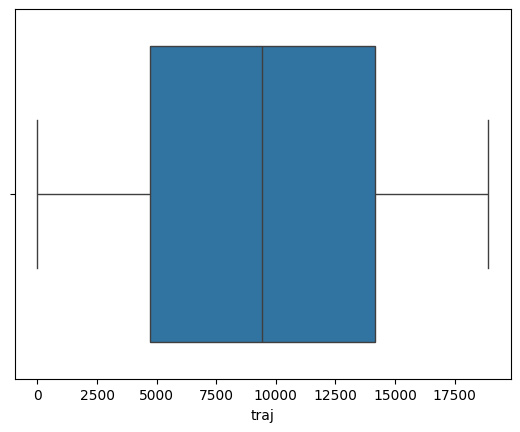

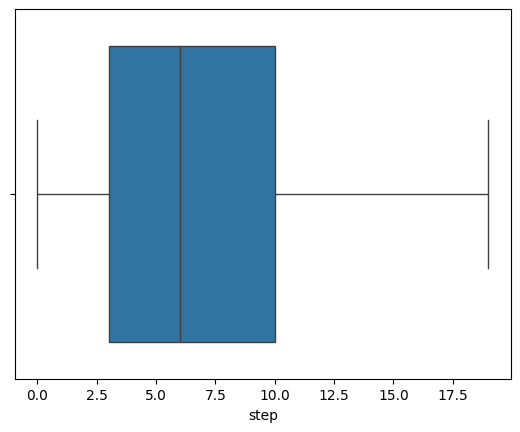

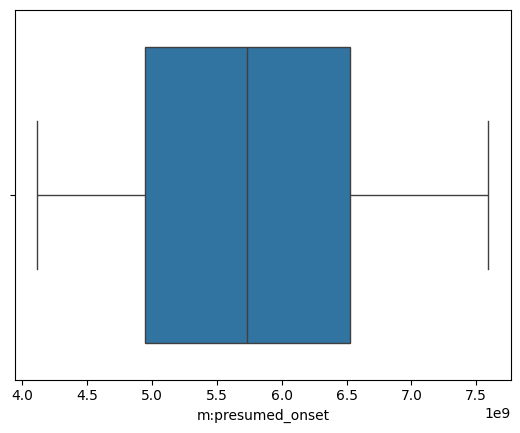

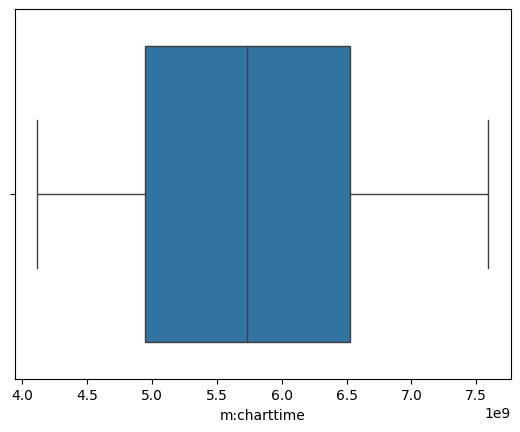

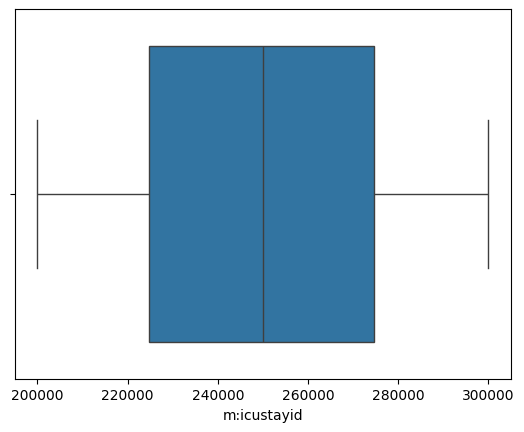

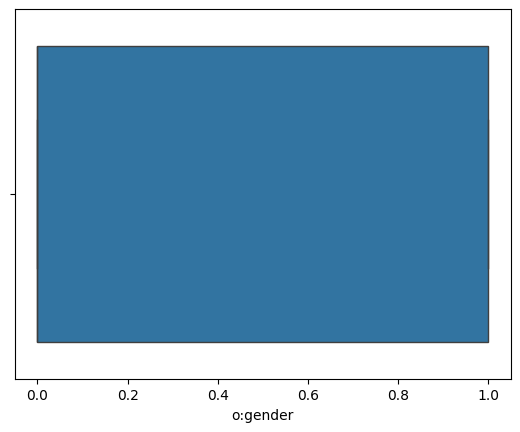

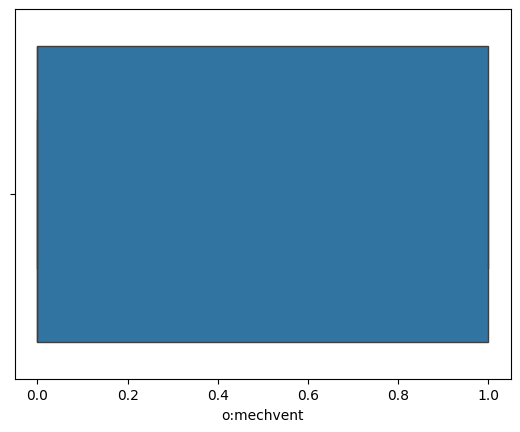

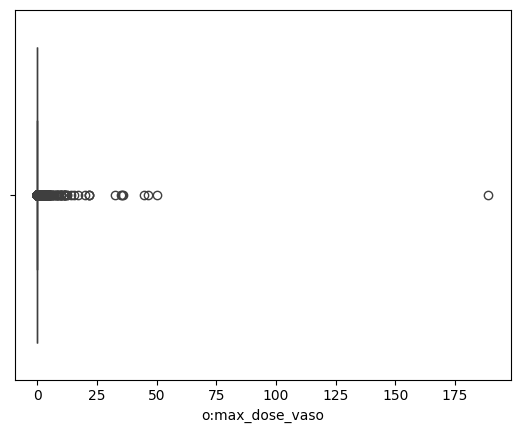

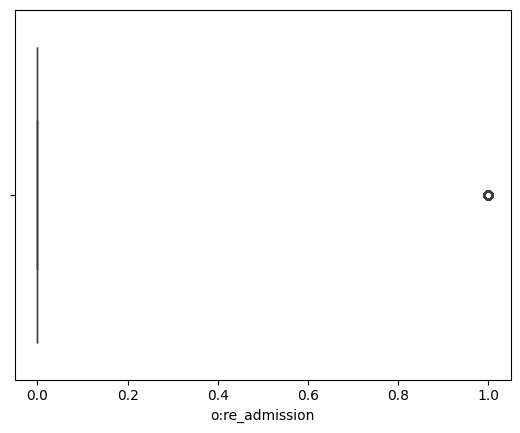

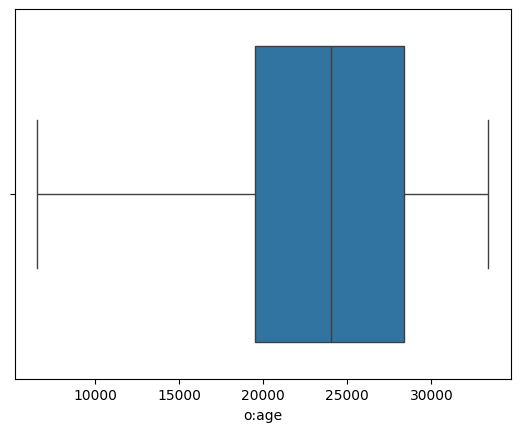

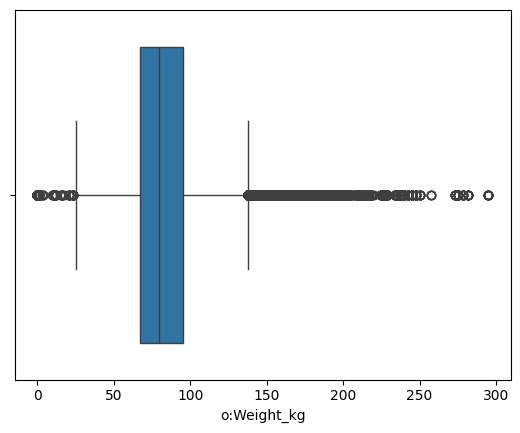

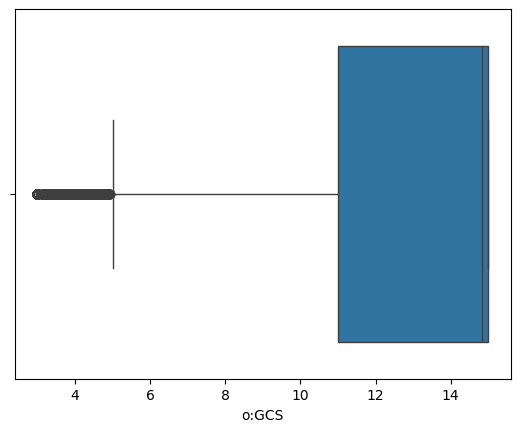

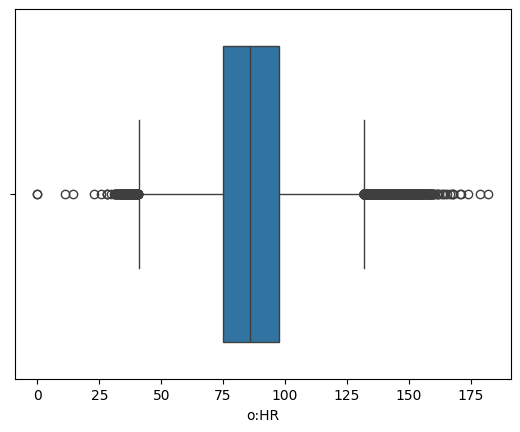

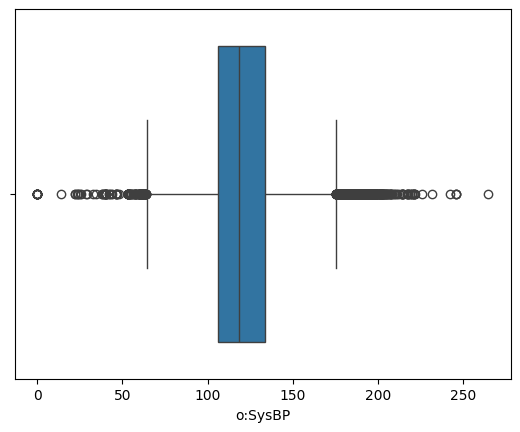

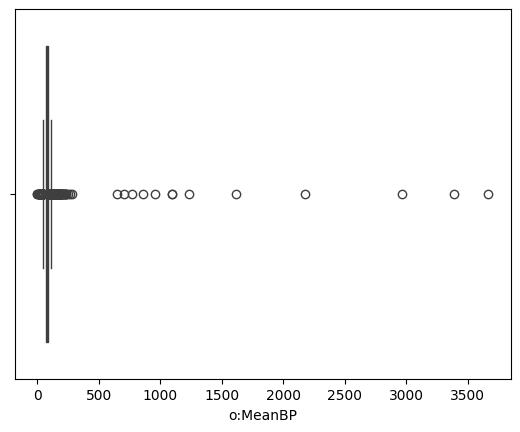

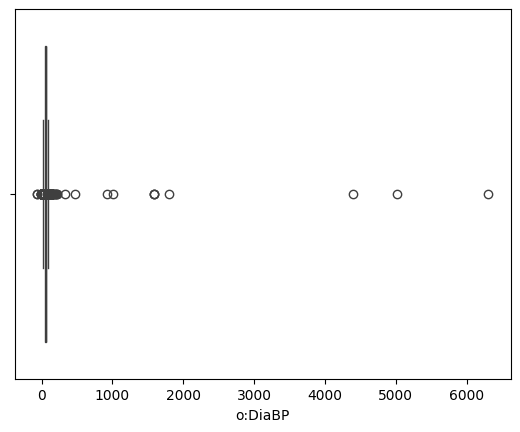

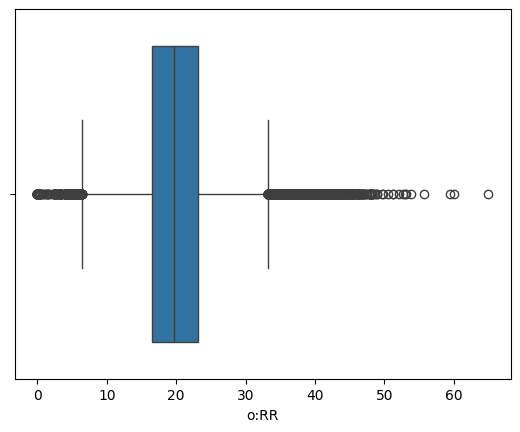

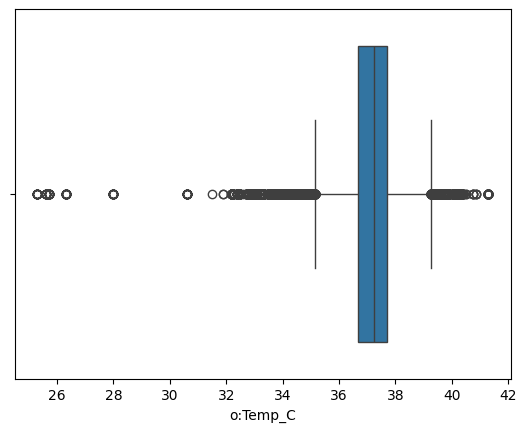

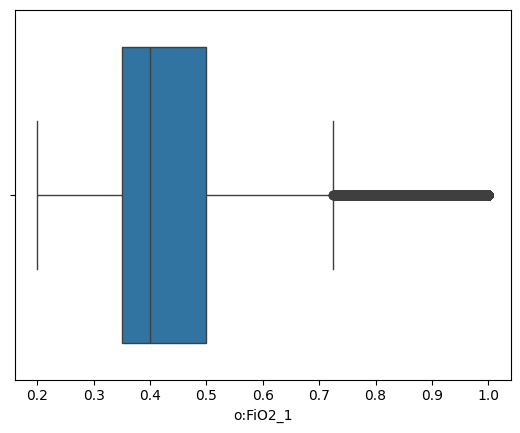

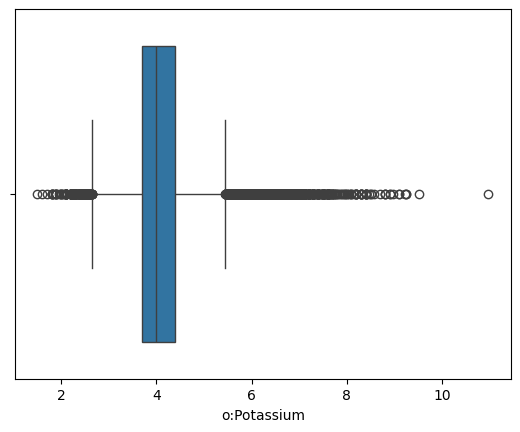

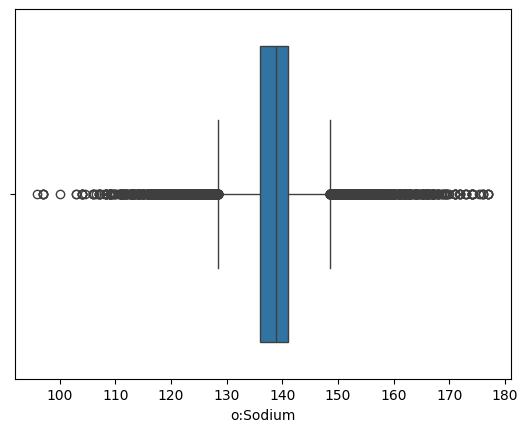

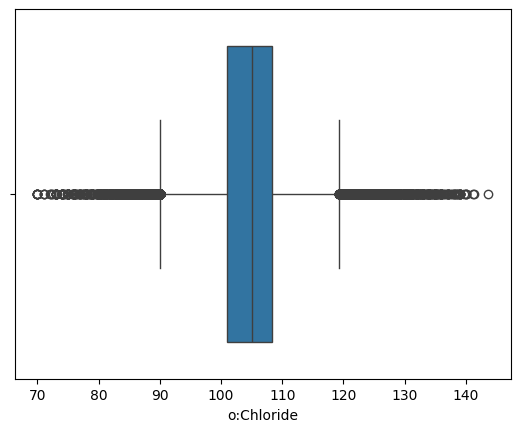

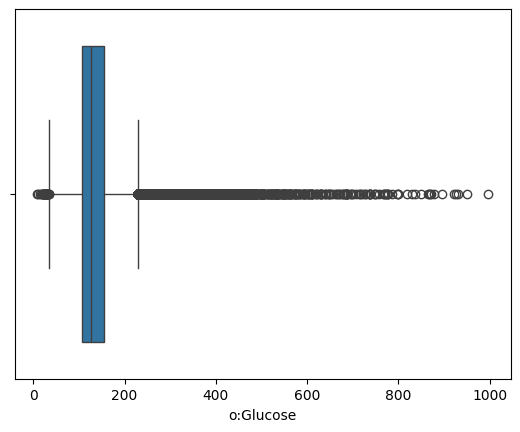

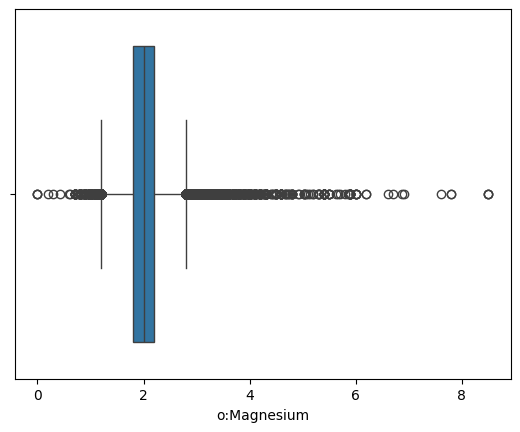

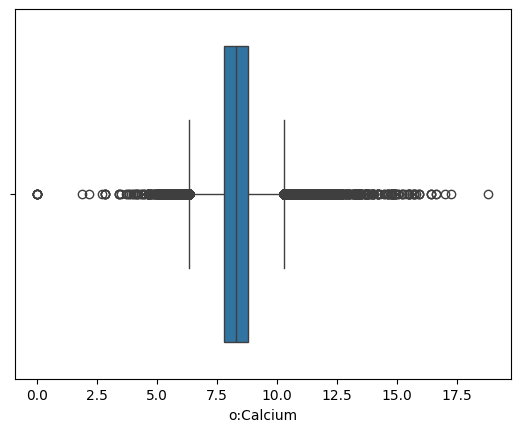

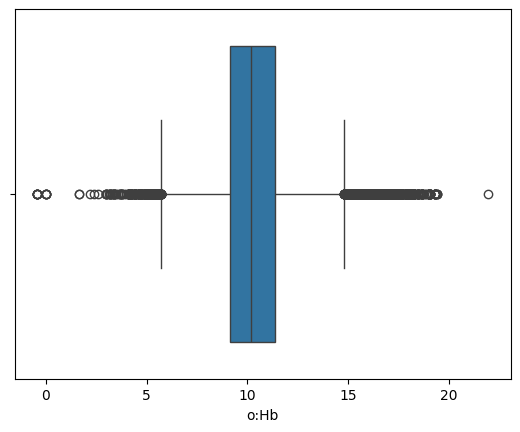

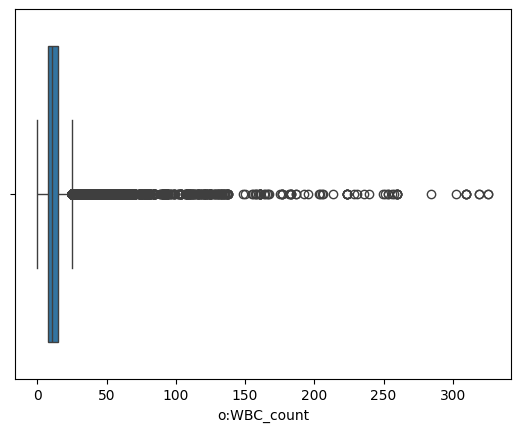

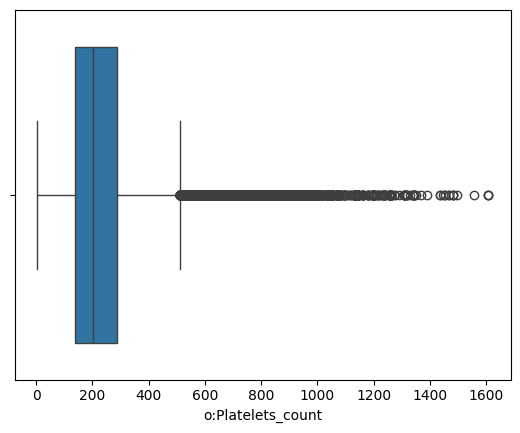

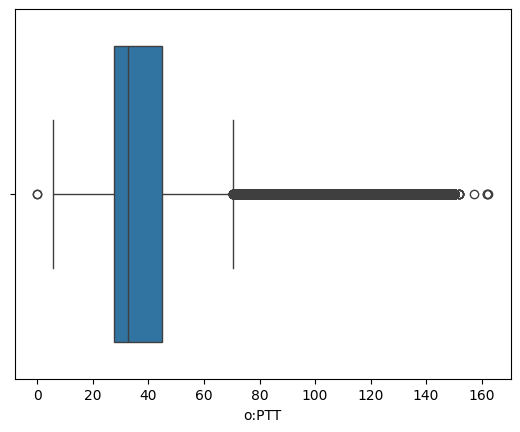

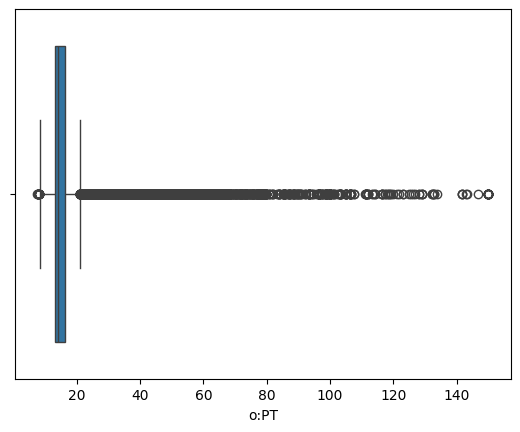

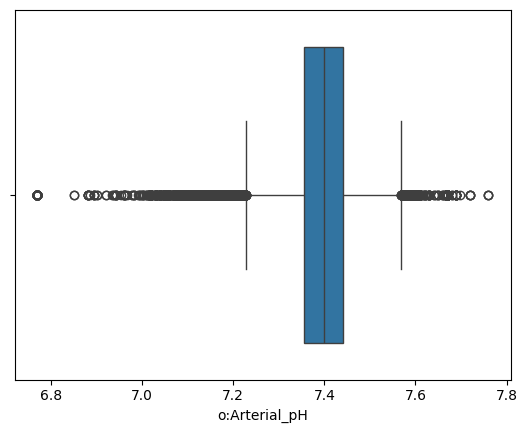

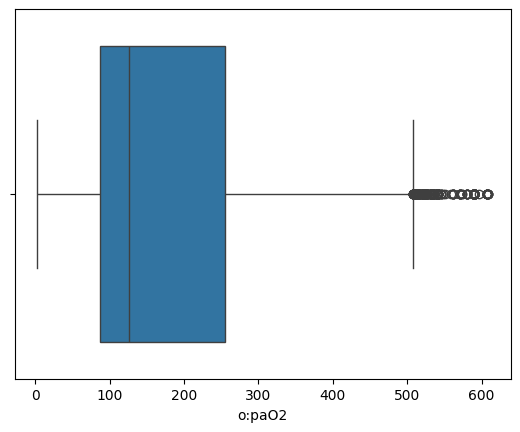

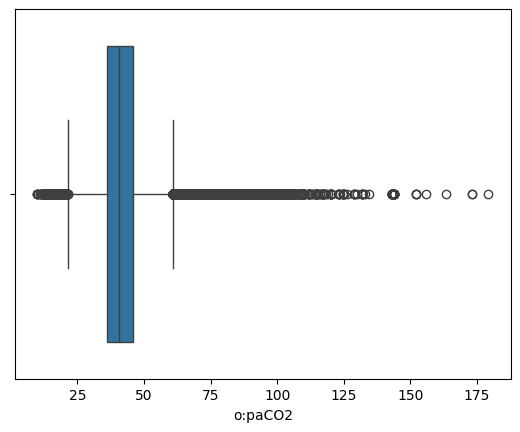

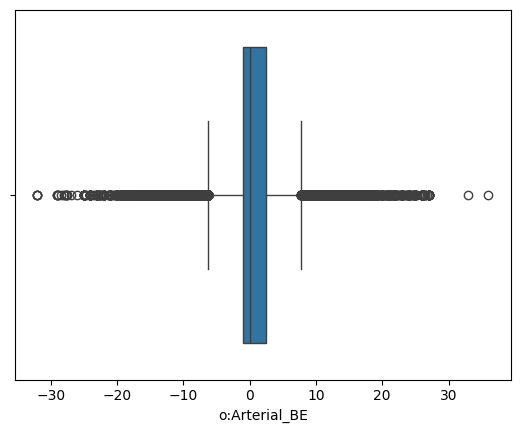

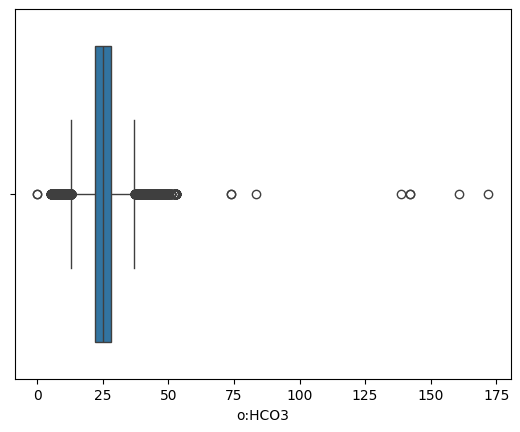

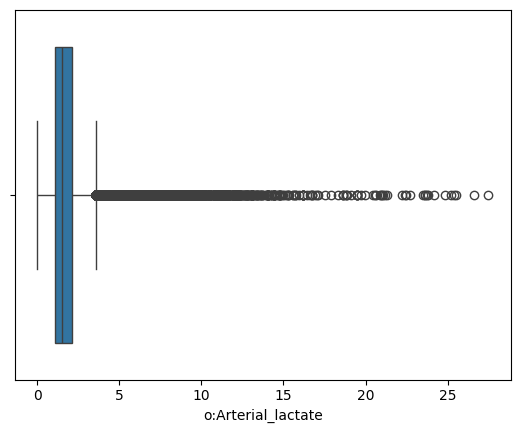

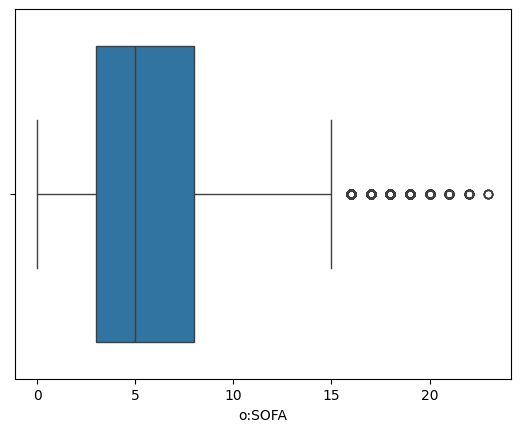

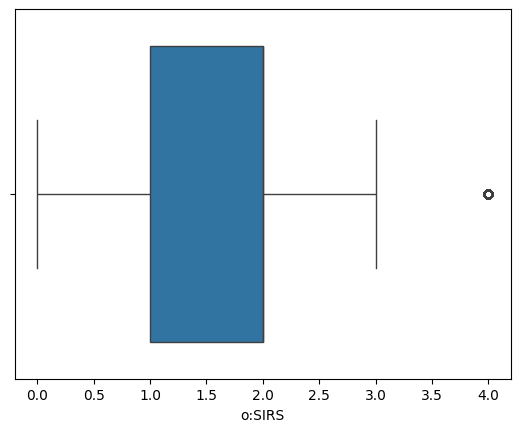

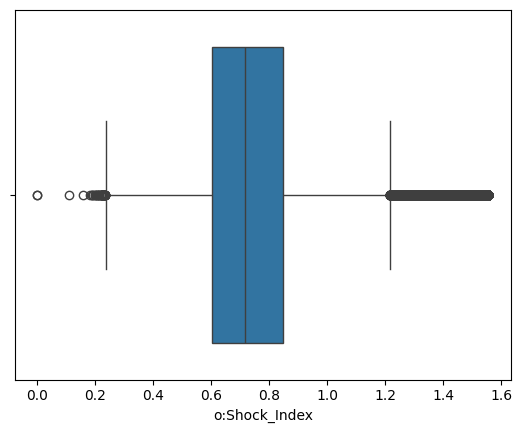

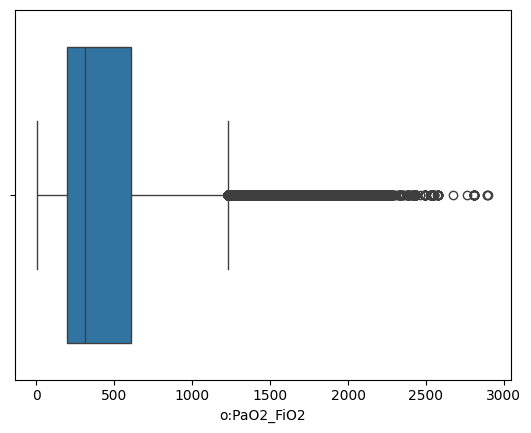

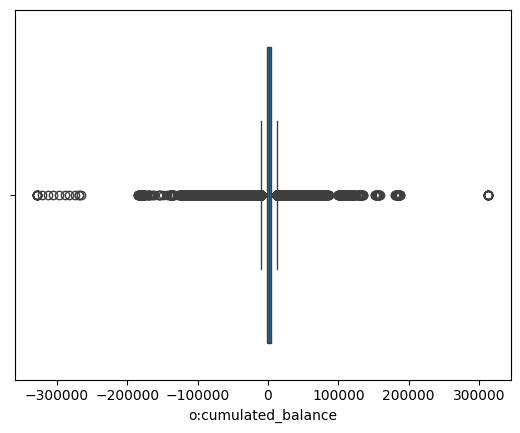

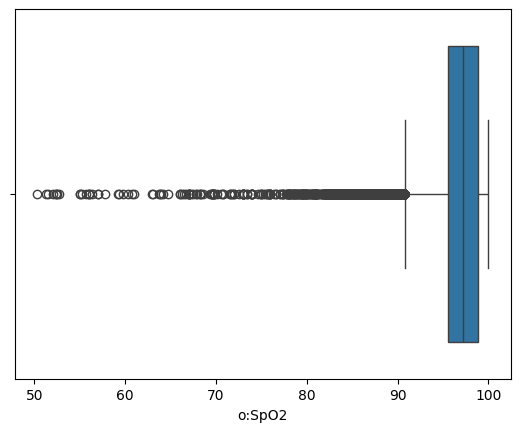

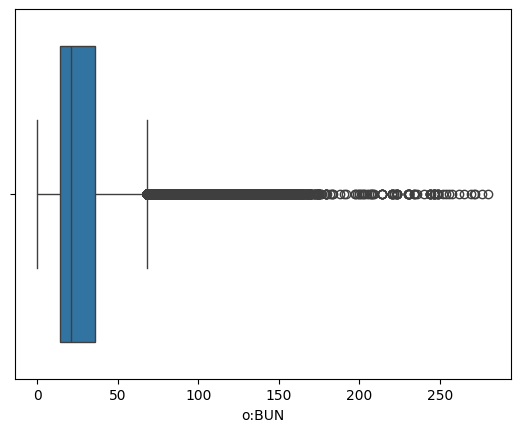

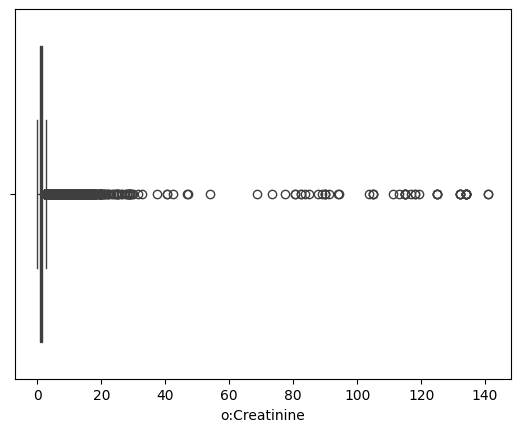

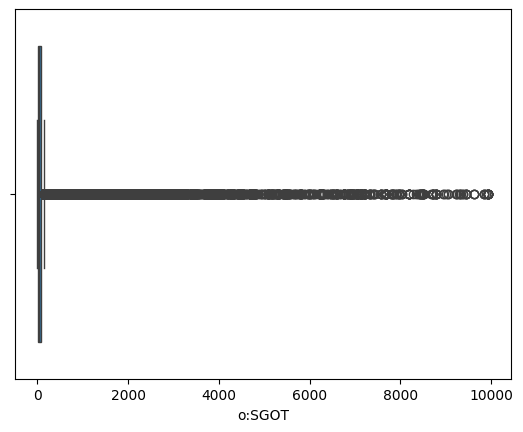

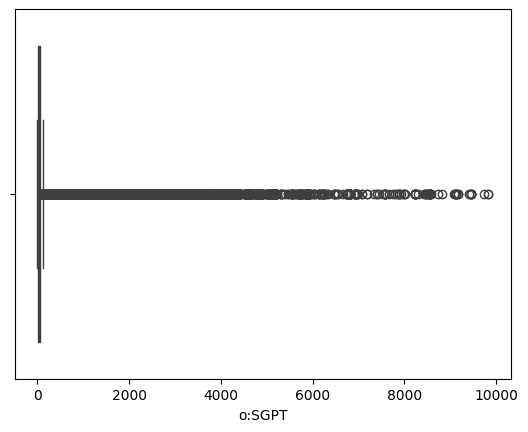

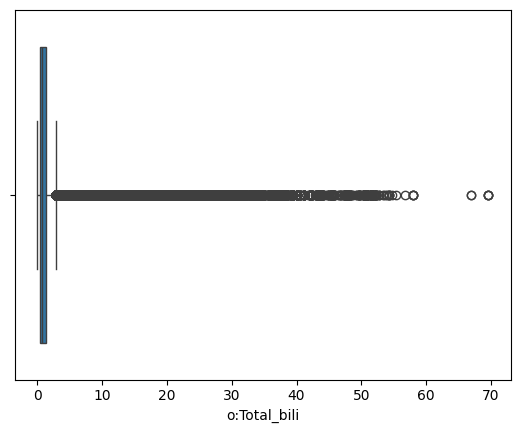

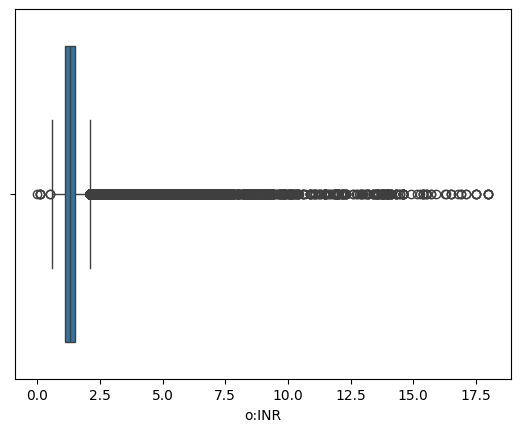

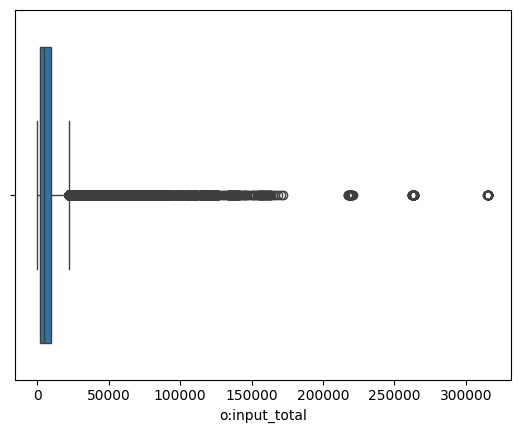

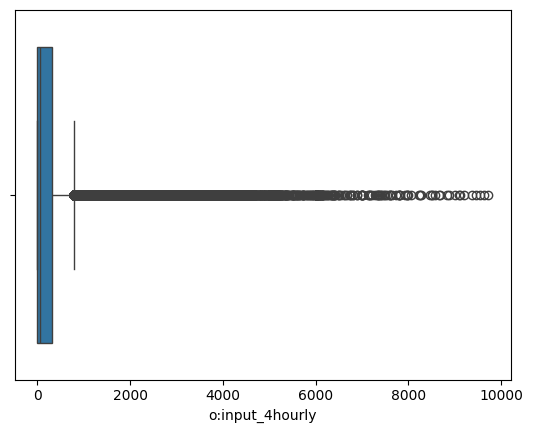

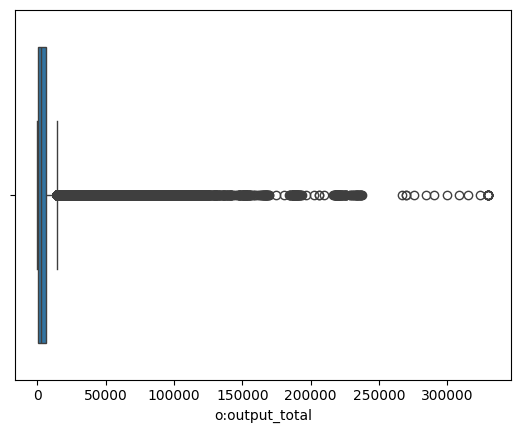

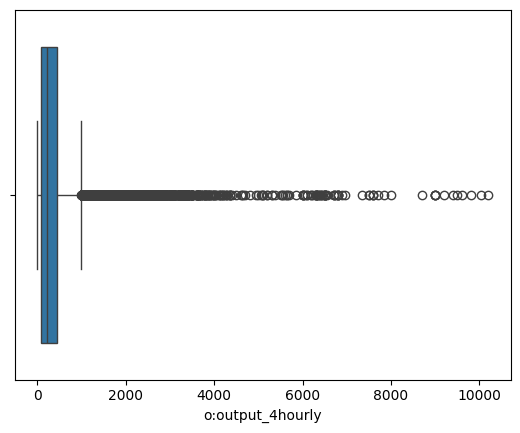

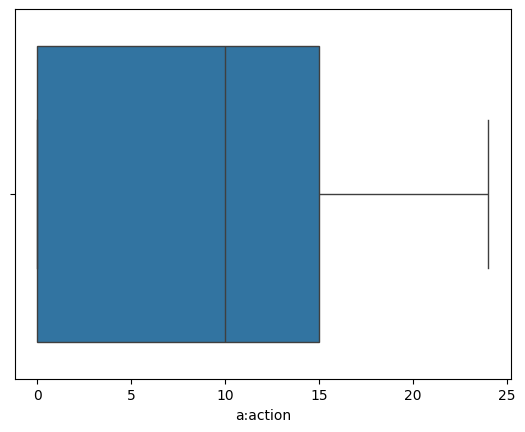

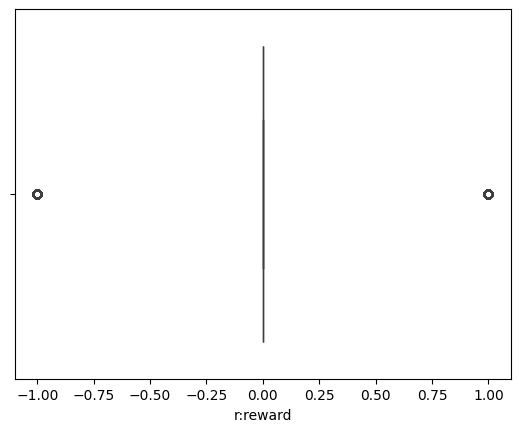

In [106]:
describe_num_df = df.describe(include=['int64','float64'])
describe_num_df.reset_index(inplace=True)
describe_num_df = describe_num_df[describe_num_df['index'] != 'count']
# print(describe_num_df['index'])
for i in num_col:  
  if i in ['index']:
    continue
  # sns.boxplot(x='index', y=i, data=describe_num_df)
  sns.boxplot(data=df, x=i)
  plt.show()

In [107]:
# I want to count how many patients died, i.e. if we group by the trajectory using "min" for aggregation,
# then "reward" column will have -1 value if the patient died and 0 if survived, because I assume that reward
# is only given one per trajectory, which is either +1 or -1.
grouped_by_traj_min = df.groupby('traj').agg('min')

In [108]:
# grouped_by_traj.columns
grouped_by_traj_min[grouped_by_traj_min['r:reward'] == 1]['r:reward']

traj
132      1.0
200      1.0
275      1.0
359      1.0
361      1.0
        ... 
18523    1.0
18557    1.0
18708    1.0
18726    1.0
18813    1.0
Name: r:reward, Length: 326, dtype: float64

- 17436 patients survivied. min reward 0.
- 326 ??? as min reward 1
- 1146 patients died. min reward -1.

by examining a few trajectories whose min reward is 1, i noticed that these trajectories consist of only 1 step. Let's check this assumption(1). And I am also interrested if there are 1-step-only-trajectories that are rewarded with -1.(2)

In [109]:
grouped_by_traj_min.columns

Index(['step', 'm:presumed_onset', 'm:charttime', 'm:icustayid', 'o:gender',
       'o:mechvent', 'o:max_dose_vaso', 'o:re_admission', 'o:age',
       'o:Weight_kg', 'o:GCS', 'o:HR', 'o:SysBP', 'o:MeanBP', 'o:DiaBP',
       'o:RR', 'o:Temp_C', 'o:FiO2_1', 'o:Potassium', 'o:Sodium', 'o:Chloride',
       'o:Glucose', 'o:Magnesium', 'o:Calcium', 'o:Hb', 'o:WBC_count',
       'o:Platelets_count', 'o:PTT', 'o:PT', 'o:Arterial_pH', 'o:paO2',
       'o:paCO2', 'o:Arterial_BE', 'o:HCO3', 'o:Arterial_lactate', 'o:SOFA',
       'o:SIRS', 'o:Shock_Index', 'o:PaO2_FiO2', 'o:cumulated_balance',
       'o:SpO2', 'o:BUN', 'o:Creatinine', 'o:SGOT', 'o:SGPT', 'o:Total_bili',
       'o:INR', 'o:input_total', 'o:input_4hourly', 'o:output_total',
       'o:output_4hourly', 'a:action', 'r:reward'],
      dtype='object')

In [110]:
# get traj values that allegetly consist only of one step
traj_values_to_check = grouped_by_traj_min[grouped_by_traj_min['r:reward'] == 1].index.tolist()
len(traj_values_to_check)

326

In [111]:
grouped_by_traj_count = df.groupby('traj').agg('count')

In [112]:
all_traj_values_with_1_step = grouped_by_traj_count[grouped_by_traj_count['step'] == 1].index.tolist()

In [113]:
len(all_traj_values_with_1_step)

335

In [114]:
set(traj_values_to_check).issubset(all_traj_values_with_1_step)

True

**We proved that, yes, 326 found trajectories with min reward 1 are all consist of 1 step**
let's see what are the other len(all_traj_values_with_1_step) - len(traj_values_to_check) = 335 - 326 = 9 one-step-trajectories. Do they all have negative reward?

In [115]:
difference = set(all_traj_values_with_1_step) - set(traj_values_to_check)
difference

{1084, 3682, 5733, 11764, 13114, 13593, 15364, 17510, 18890}

In [116]:
df[df['traj'].isin(difference)]['r:reward']

14093    -1.0
48425    -1.0
75277    -1.0
154314   -1.0
171797   -1.0
178216   -1.0
201386   -1.0
229316   -1.0
247215   -1.0
Name: r:reward, dtype: float64

**So, yes. For 9 other one-step-trajectories the reward is negative, i.e the patient died**

### To sum up

Overall: 
- 17436 + 326 = 17762 patients survived, where 326 are one-step-trajectories and 17436 are not.
- 1137 + 9 = 1146 patients died, where 9 are one-step-trajectories and 1137 are not.


In [117]:
# How many were readmitted?
# grouped_by_traj_min dataset is suitable to explore this question, because icustayid does not change within 1 trajectory
# therefore min() does not affect icustayid
# readmission is also does not change within 1 trajectory
grouped_by_id_sum = grouped_by_traj_min.groupby('m:icustayid').agg('sum')

In [118]:
grouped_by_id_sum[grouped_by_id_sum['o:re_admission'] == 1]

,step,m:presumed_onset,m:charttime,o:gender,o:mechvent,o:max_dose_vaso,o:re_admission,o:age,o:Weight_kg,o:GCS,...,o:SGOT,o:SGPT,o:Total_bili,o:INR,o:input_total,o:input_4hourly,o:output_total,o:output_4hourly,a:action,r:reward
m:icustayid,,,,,,,,,,,,,,,,,,,,,
200011.0,0,6.898284e+09,6.898241e+09,1.0,0.0,0.0,1.0,30766.069028,101.400000,10.000000,...,29.0,21.0,0.3,0.9,0.000000,0.000000,0.0,0.0,0,0.0
200147.0,0,5.585155e+09,5.585051e+09,1.0,0.0,0.0,1.0,28816.021400,63.799999,10.800000,...,26.0,18.0,0.4,1.1,2639.500000,0.000000,4470.0,0.0,0,0.0
200215.0,0,6.726237e+09,6.726231e+09,0.0,0.0,0.0,1.0,30552.920637,71.800000,15.000000,...,24.0,24.0,0.3,1.4,433.333333,40.000000,250.0,150.0,5,0.0
200350.0,0,5.753722e+09,5.753710e+09,1.0,0.0,0.0,1.0,29151.931331,53.300000,14.333333,...,27.0,62.0,0.5,3.2,400.000000,0.000000,0.0,0.0,0,0.0
200477.0,0,5.175014e+09,5.175069e+09,0.0,1.0,0.0,1.0,33383.850000,74.000000,6.000000,...,24.0,29.0,0.7,1.2,58.519250,0.000000,230.0,125.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299679.0,0,6.968466e+09,6.968365e+09,0.0,0.0,0.0,1.0,30909.178900,72.199997,14.000000,...,10.0,6.0,0.3,0.9,390.000000,0.000000,2515.0,0.0,0,0.0
299820.0,0,6.586339e+09,6.586236e+09,0.0,1.0,0.0,1.0,18953.774410,51.000000,6.000000,...,18.0,10.0,0.2,1.5,1633.800567,16.833333,8010.0,380.0,5,0.0
299840.0,0,4.663139e+09,4.663037e+09,1.0,1.0,0.0,1.0,27792.973368,59.000000,7.800000,...,9.0,6.0,0.3,1.0,24329.500000,0.000000,18451.0,105.0,0,0.0


In [119]:
grouped_by_id_sum[grouped_by_id_sum['o:re_admission'] > 1]

,step,m:presumed_onset,m:charttime,o:gender,o:mechvent,o:max_dose_vaso,o:re_admission,o:age,o:Weight_kg,o:GCS,...,o:SGOT,o:SGPT,o:Total_bili,o:INR,o:input_total,o:input_4hourly,o:output_total,o:output_4hourly,a:action,r:reward
m:icustayid,,,,,,,,,,,,,,,,,,,,,


So, my hypothesis was that there might be 1 patient that was treated twice that has therefore the same icustayid, i.e readmission == 1 for these both rows with the same icustayid. If it was true, the expression above would give more than 0 rows. But it is not. So, it means that even though in the data there might be more than one same person's trajectories, we have no possibility to identify these people as they have different icustayid and therefore we can only treat them as two different people. The only information that we could make use of is the fact that a person was readmitted or that he or she was not. 

1376 patients were readmitted which is

In [120]:
print(round((1376 / 18908) * 100, 1), '%')

7.3 %


In [121]:
# Just to be sure that icustay ids are never repeating in the data 
grouped_by_traj_min["m:icustayid"].nunique()

18908

18908 corresponds to the number of trajectories, meaning that there is 1-1 mapping from icustayid to traj, and from the data we see that on every step of a trajectory icustayid is the same. Therefore, it's a bijection.


It also means that icustayid does not carry any additional to trajectory number information. Therefore, could be probably omitted without changing the result of any algorithm applied to the data.

In [122]:
# 1376 were readmitted, but if the patient was readmitted - we treat him/her as a new case!

In [123]:
# Example of one icustayid -> only connected with 1 trajectory.
df[df["m:icustayid"]==299881.0]

,traj,step,m:presumed_onset,m:charttime,m:icustayid,o:gender,o:mechvent,o:max_dose_vaso,o:re_admission,o:age,...,o:SGOT,o:SGPT,o:Total_bili,o:INR,o:input_total,o:input_4hourly,o:output_total,o:output_4hourly,a:action,r:reward
247179,18887,0,5.784998e+09,5.784894e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,16.000000,16.000000,0.900000,1.800000,60.0,50.0,0.0,0.0,10,0.0
247180,18887,1,5.784998e+09,5.784908e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,218.000000,94.000000,0.800000,1.000000,105.0,45.0,0.0,0.0,5,0.0
247181,18887,2,5.784998e+09,5.784923e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,218.000000,94.000000,0.800000,1.000000,130.0,25.0,0.0,0.0,5,0.0
247182,18887,3,5.784998e+09,5.784937e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,218.000000,94.000000,0.800000,1.033333,170.0,40.0,0.0,0.0,5,0.0
247183,18887,4,5.784998e+09,5.784952e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,206.571429,70.428571,0.871429,1.100000,270.0,100.0,0.0,0.0,10,0.0
247184,18887,5,5.784998e+09,5.784966e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,206.571429,70.428571,0.871429,1.100000,330.0,60.0,0.0,0.0,10,0.0
247185,18887,6,5.784998e+09,5.784980e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,206.571429,70.428571,0.871429,1.100000,330.0,0.0,0.0,0.0,0,0.0
247186,18887,7,5.784998e+09,5.785009e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,113.000000,74.000000,0.200000,1.100000,330.0,0.0,0.0,0.0,0,0.0
247187,18887,8,5.784998e+09,5.785024e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,32.000000,16.000000,3.600000,1.100000,330.0,0.0,0.0,0.0,0,0.0
247188,18887,9,5.784998e+09,5.785038e+09,299881.0,1.0,0.0,0.0,1.0,21754.642535,...,32.000000,16.000000,3.600000,1.200000,330.0,0.0,0.0,0.0,0,0.0


In [124]:
grouped_by_traj_min[grouped_by_traj_min["o:re_admission"] > 0].shape[0]

1376

In [125]:
# 17762 times reward was 1.0

In [126]:
number_of_patients_to_model = 2

In [127]:
time_variant_properties = ['step', 'm:charttime',
        'o:mechvent', 'o:max_dose_vaso', 'o:re_admission',
       'o:Weight_kg', 'o:GCS', 'o:HR', 'o:SysBP', 'o:MeanBP', 'o:DiaBP',
       'o:RR', 'o:Temp_C', 'o:FiO2_1', 'o:Potassium', 'o:Sodium', 'o:Chloride',
       'o:Glucose', 'o:Magnesium', 'o:Calcium', 'o:Hb', 'o:WBC_count',
       'o:Platelets_count', 'o:PTT', 'o:PT', 'o:Arterial_pH', 'o:paO2',
       'o:paCO2', 'o:Arterial_BE', 'o:HCO3', 'o:Arterial_lactate', 'o:SOFA',
       'o:SIRS', 'o:Shock_Index', 'o:PaO2_FiO2', 'o:cumulated_balance',
       'o:SpO2', 'o:BUN', 'o:Creatinine', 'o:SGOT', 'o:SGPT', 'o:Total_bili',
       'o:INR', 'o:input_total', 'o:input_4hourly', 'o:output_total',
       'o:output_4hourly', 'a:action', 'r:reward']

In [128]:
# df.columns

In [129]:
# for i in range(1, number_of_patients_to_model+1):
#     patient_df = df[df['traj'] == i]
#     # Time-invariant properties
#     age = patient_df['o:age'].iloc[0]
#     gender = patient_df['o:gender'].iloc[0]
#     re_admission = patient_df['o:re_admission'].iloc[0]
#     icustayid = patient_df['m:icustayid'].iloc[0]
#     presumed_onset = patient_df['m:presumed_onset'].iloc[0]
    
#     for index, row in patient_df.iterrows():
#         row_dict = row.to_dict()  # Convert the Series to a dictionary
#         # Extract not time-invariant properties too
#         # Create nodes in neo4j
    

In [130]:
# Function to create nodes and relationships in Neo4j
def create_patient_graph(session, traj, age, gender, re_admission, icustayid, presumed_onset, time_steps):
    print(f"{traj}")
    # Create the patient node with time-invariant properties
    create_patient_query = """
        CREATE (p:Patient {traj: $traj, age: $age, gender: $gender, re_admission: $re_admission,
        icustayid: $icustayid, presumed_onset: $presumed_onset})
        RETURN elementId(p) as node_id
    """
    patient_node_neo4j_id = session.run(create_patient_query,
                            traj=traj,
                            age=age, gender=gender,
                            re_admission=re_admission,
                            icustayid=icustayid,
                            presumed_onset=presumed_onset
                           ).single()['node_id']
    print(f"{patient_node_neo4j_id=}")

    # Create time steps and time-variant property nodes
    time_step_node_ids = []
    # CREATE (charlie:Person:Actor {name: 'Charlie Sheen'})-[:ACTED_IN {role: 'Bud Fox'}]->(wallStreet:Movie {title: 'Wall Street'})<-[:DIRECTED]-(oliver:Person:Director {name: 'Oliver Stone'})
    terminal = False
    for i, time_step in enumerate(time_steps):

        if i == len(time_steps) - 1:
            # This is the last step in the trajectory
            terminal = True
        
        # commented out temporarily to debug
        time_step_node_query = """
        MATCH (p: Patient)
        WHERE elementId(p) = $patient_node_neo4j_id
        CREATE (t:TimeStep {step: $step, charttime: $charttime, mechvent: $mechvent, 
            max_dose_vaso: $max_dose_vaso, Weight_kg: $Weight_kg, GCS: $GCS, HR: $HR,
            SysBP: $SysBP, MeanBP: $MeanBP, DiaBP: $DiaBP, RR: $RR, Temp_C: $Temp_C,
            FiO2_1: $FiO2_1, Potassium: $Potassium, Sodium: $Sodium, Chloride: $Chloride,
            Glucose: $Glucose, Magnesium: $Magnesium, Calcium: $Calcium, Hb: $Hb,
            WBC_count: $WBC_count, Platelets_count: $Platelets_count, PTT: $PTT,
            PT: $PT, Arterial_pH: $Arterial_pH, paO2: $paO2, paCO2: $paCO2, Arterial_BE: $Arterial_BE,
            HCO3: $HCO3, Arterial_lactate: $Arterial_lactate, SOFA: $SOFA, SIRS: $SIRS,
            Shock_Index: $Shock_Index, PaO2_FiO2: $PaO2_FiO2, cumulated_balance: $cumulated_balance,
            SpO2: $SpO2, BUN: $BUN, Creatinine: $Creatinine, SGOT: $SGOT, SGPT: $SGPT,
            Total_bili: $Total_bili, INR: $INR, input_total: $input_total, input_4hourly: $input_4hourly,
            output_total: $output_total, output_4hourly: $output_4hourly, reward: $reward, terminal: $terminal})
        CREATE (p)-[:HAS_TIMESTEP]->(t)
        RETURN elementId(t) as ts_node_id
        """
        
        
        result = session.run(time_step_node_query, 
                        {**time_step, 'patient_node_neo4j_id': patient_node_neo4j_id, 'terminal': terminal}
                       ).single()
        print(result)
        time_step_node_ids.append(result["ts_node_id"])
        
        

    # Create edges with actions between consecutive time steps
    for idx in range(len(time_step_node_ids) - 1):
        current_node_id = time_step_node_ids[idx]
        next_node_id = time_step_node_ids[idx + 1]
        action = time_steps[idx].get('action')  # Action leading from current step to next step

        res = session.run("""
            MATCH (curr:TimeStep), (next:TimeStep)
            WHERE elementId(curr) = $current_node_id AND elementId(next) = $next_node_id
            CREATE (curr)-[:NEXT_TIME_STEP {action: $action}]->(next)
            RETURN elementId(curr) AS curr_id, elementId(next) AS next_id
            """, current_node_id=current_node_id, next_node_id=next_node_id, action=action)
        # for record in res:
        #     print("Current Node ID:", record["curr_id"])
        #     print("Next Node ID:", record["next_id"])

    

      


In [131]:
def clean_name_of_column(old_name: str):
    if ':' in old_name:
        # Use regex to capture the part after the colon
        match = re.search(r':\s*(.+)', old_name)
        return match.group(1).strip()
    else:
        # If no colon, return the whole text stripped
        return old_name.strip()
       

In [132]:
def patient_exists(session, traj):
    query = """
    MATCH (p:Patient {traj: $traj})
    RETURN p LIMIT 1
    """
    result = session.run(query, traj=traj)
    
    return result.single() is not None  # True if patient exists, False otherwise


In [133]:
# Loop through patients and time steps, and add them to Neo4j
def add_patients_to_graph(df, number_of_patients_to_model):
    with driver.session() as session:
        for i in range(1, number_of_patients_to_model + 1):
            if patient_exists(session, traj=i):
                print(f"Patient with traj {i} already exists. Skipping...")
                continue
            patient_df = df[df['traj'] == i]
            # Extract time-invariant properties
            # We assume that these properties are constant over one trajcetory, therefore we retreive only a first one(with index=0)
            age = patient_df['o:age'].iloc[0]
            gender = patient_df['o:gender'].iloc[0]
            re_admission = patient_df['o:re_admission'].iloc[0]
            icustayid = patient_df['m:icustayid'].iloc[0]
            presumed_onset = patient_df['m:presumed_onset'].iloc[0]
            
            # Extract time-variant properties for each time step
            time_steps = []
            time_step_data = {}
            for index, row in patient_df.iterrows():
                row_dict = row.to_dict()
                time_step_data = {clean_name_of_column(key): row_dict[key] for key in time_variant_properties}
                # print(time_step_data)
                time_steps.append(time_step_data)

            # Add the patient and their time steps to Neo4j
            # session.write_transaction(create_patient_graph, i, age, gender, re_admission, icustayid, presumed_onset, time_steps)
            create_patient_graph(session, i, age, gender, re_admission, icustayid, presumed_onset, time_steps)



In [134]:
add_patients_to_graph(df, number_of_patients_to_model=7)  # Add patients to the Neo4j graph

Patient with traj 1 already exists. Skipping...
Patient with traj 2 already exists. Skipping...
Patient with traj 3 already exists. Skipping...
Patient with traj 4 already exists. Skipping...
Patient with traj 5 already exists. Skipping...
Patient with traj 6 already exists. Skipping...
Patient with traj 7 already exists. Skipping...


In [135]:
#TODO
# Take into account readmission. How should it look like if a patient was readmitted?
